In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

print(tf.__version__)
print("GPU is","available" if tf.config.list_physical_devices('GPU') else "NOTAVAILABLE")

2.1.0
GPU is NOTAVAILABLE


In [2]:
train_image_path = glob.glob('face/*.jpg')

In [3]:
len(train_image_path)

6937

In [4]:
#train_image_label = [int(p.split('\\')[1]=='cat') for p in train_image_path]

In [5]:
#定义一个函数用来加载和预处理图片数据
def load_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels = 3)
    image = tf.image.resize(image,[96,96])

    #image = tf.image.random_crop(image,[256,256,3])
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_brightness(image,0.5)
    #image = tf.image.random_contrast(image,0,1)
    
    image = tf.cast(image, tf.float32)
    image = image/255  # normalize to [0,1] range
   
    return image

In [6]:
# 构建图片路径的“dataset”
train_image_ds = tf.data.Dataset.from_tensor_slices(train_image_path)
#使用AUTOTUNE自动调节管道参数
AUTOTUNE = tf.data.experimental.AUTOTUNE
#构建图片数据的“dataset”
train_images = train_image_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)
train_images

<ParallelMapDataset shapes: (96, 96, 3), types: tf.float32>

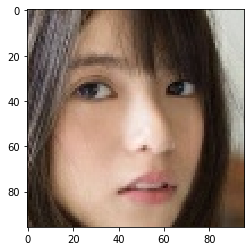

In [7]:
for img in train_images.take(1):
    plt.imshow(img)

In [8]:
BUFFER_SIZE = 8000
BATCH_SIZE =16

In [9]:
# Batch and shuffle the data
# 将数据打乱，BUFFER_SIZE越大，混乱程度越大；按照顺序取出BATCH_SIZE行数据
train_dataset = train_images.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 96, 96, 3), types: tf.float32>

# 建立GAN模型

In [10]:
def make_generator_model(): 
    """
      使用Sequential API来建立生成器与判别器模型
      1.网络结构包括 Conv2DTranspose反卷积层
      2.使用全连接层，并对图片进行两次上采样，来得到期望尺寸96x96x3
      3.增加宽和高，并且减少网络深度
      4.使用Leaky Relu()
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((12, 12, 256))) # reshape回去
    assert model.output_shape == (None, 12, 12, 256) # None是batchsize不定
    
    # 反卷积1次
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 反卷积2次
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 反卷积3次，获得96，96，3维度
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, 
                                     activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model


In [11]:
def make_discriminator_model():
    """
      判别器模型，与基本CNN图片二分类器类似
    """
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36864)             3686400   
_________________________________________________________________
batch_normalization (BatchNo (None, 36864)             147456    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36864)             0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 128)       0

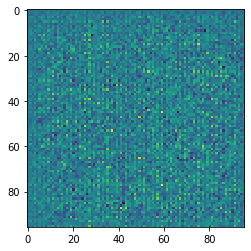

In [12]:
#噪音图像生成预览(生成器生成图片)并查看生成器网络结构
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
#noise = np.random.uniform(0,1,size=[1,100])
generated_image = generator(noise, training=False)
#plt.imshow(generated_image[0, :, :, 0], cmap='Accent')
#generated_image=tf.clip_by_value(generated_image[0,:,:,:], 0, 1)
plt.imshow(generated_image[0,:,:,0])

In [13]:
#判别器判别并查看判别器网络结构
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)            

In [14]:
# This method returns a helper function to compute cross entropy loss
# 该方法返回一个辅助函数来计算交叉熵损失
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    """
      判别器loss计算过程：
      1.计算real_loss它是真实图像和一组1的交叉熵损失(因为这些是真实图像)
      2.计算generated_loss它是生成的图像和一组0的交叉熵损失(因为这些是假图像)。
      3.计算total_loss=sum(real_loss,generated_loss)
    """
    # [1,1,1...1]是真实图像，因为它是真实的，所以我们希望生成的示例看起来像它
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # [0,0,…，0]生成图像，因为它们是假的
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def generator_loss(fake_output):
    """生成器loss"""
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# 判别与生成优化器是不同的，我们要各自训练
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
# Checkpoints(object-based saving) checkpoint保持
checkpoint_dir = './GANOutput/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [141]:
# ----------配置GAN进行训练------------
# set up Generative Adversarial Networks
# 定义training的超参数
EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 36

In [22]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
# 我们将重复使用此种子（这样更容易以可视化方式显示GIF动画中的进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)

(36, 100)


In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# 定义训练方法
# 生成器：以一个正态分布的噪声作为输入，目的是产生一个与人像类似的图像。
# 判别器：展示真正的人像，并评价这个生成器生成的图像。
# 计算generator和discriminator的loss。然后，我们计算关于generator以及
# discrinminator变量的loss的梯度
# 另外使用了`tf.function`注解，使函数被“编译”为计算图模式
@tf.function
def train_step(images):
    # 产生正态分布的噪声
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    """
      确保training参数设置是False,这是为了让所有层在推理模式下运行(batchnorm)。
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(6, 6, i+1)
        predictions_rgb=tf.clip_by_value(predictions[i,:,:,:],0,1)
        #tf.clip_by_value(V, min, max), 截取V使之在min和max之间
        #tf.clip_by_value(v, 2.5, 4.5)
        #[[ 2.5  2.5  4. ]
        #[ 4.   4.5  4.5]]
        plt.imshow(predictions_rgb)
        plt.axis('off') # 关闭坐标轴

    plt.savefig('./GANOutput/Pictures/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [259]:
def train(dataset, epochs):
    """训练过程"""
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        # Save the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Generate after the final epoch
    # 最后的epoch后进行generating
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [258]:
model_filename = tf.train.latest_checkpoint(checkpoint_dir)
print(model_filename)

if model_filename != None:
    checkpoint.restore(model_filename)
    print("checkpoint file {} restored!".format(model_filename))
else:
    print("Can't find checkpoint file!")

./GANOutput/training_checkpoints\ckpt-4
checkpoint file ./GANOutput/training_checkpoints\ckpt-4 restored!


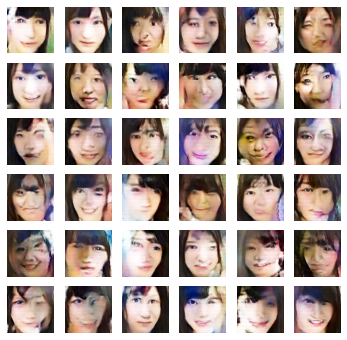

In [25]:
#模型训练
#%%time  #给出cell的代码运行一次所花费的时间
train(train_dataset, EPOCHS)

In [26]:
generator.save('./GANOutput//detect_v1.h5')

In [261]:
new_generator = tf.keras.models.load_model('./GANOutput//detect_v1.h5')

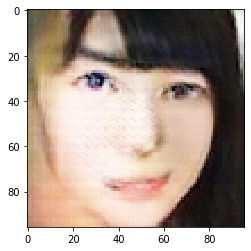

In [676]:
noise = tf.random.normal([1, 100])
#noise = np.random.uniform(0,1,size=[1,100])
predictions = new_generator(noise, training=False)
predictions_rgb=tf.clip_by_value(predictions[0,:,:,:],0,1)
plt.imshow(predictions_rgb)

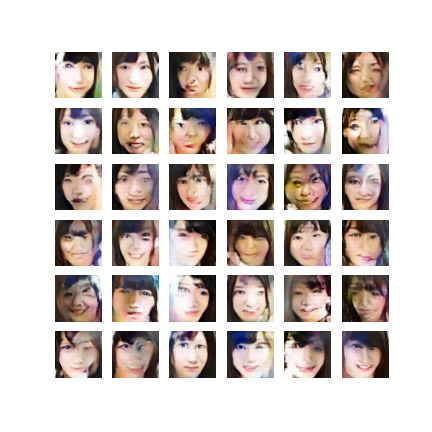

In [144]:
def display_image(epoch_no):
  return PIL.Image.open('./GANOutput/Pictures/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

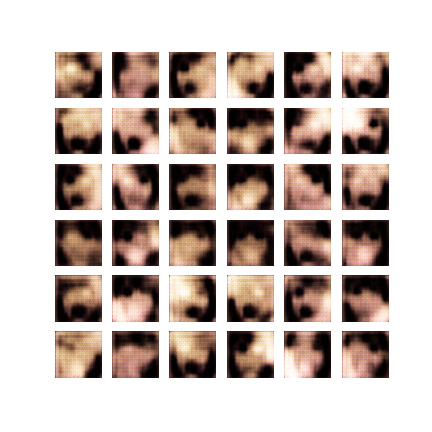

In [30]:
anim_file = './GANOutput/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./GANOutput/Pictures/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

# A hack to display the GIF inside this notebook
os.rename('./GANOutput/dcgan.gif', './GANOutput/dcgan.gif.png')
display.Image(filename="./GANOutput/dcgan.gif.png")